# <center> Shape analysis of cancer cells </center>

This notebook studies *Osteosarcoma* (bone cancer) cells and the impact of drug treatment on their *morphological shapes*, by analyzing cell images obtained from fluorescence microscopy. 

This analysis relies on the *elastic metric between discrete curves* from Geomstats. We will study to which extent this metric can detect how the cell shape is associated with the response to treatment.

This notebook is adapted from Florent Michel's submission to the [ICLR 2021 Computational Geometry and Topology challenge](https://github.com/geomstats/challenge-iclr-2021).

<center>
    <img src='figures/cells_image.png' width=600px>
</center>

Figure 1: Representative images of the cell lines using fluorescence microscopy, studied in this notebook (Image credit : Ashok Prasad). The cells nuclei (blue), the actin cytoskeleton (green) and the lipid membrane (red) of each cell are stained and colored. We only focus on the cell shape in our analysis.

# 1. Introduction and motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology [(MGCKCKDDRTWSBCC2018)](#References). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell lines treated with different drugs [(AXCFP2019)](#References).

As a metric defined on the shape space of curves, the *elastic metric* [(SKJJ2010)](#References), which is implemented in Geomstats, is another potential tool for analyzing and comparing biological cell shapes. While its associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing shapes, this metric, to our knowledge, has not been applied so far to analyze biological cells. 

# 2. Analysis

### Setup

In [7]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import geomstats.backend as gs

gs.random.seed(2021)

## 2.1. Dataset description

We study a dataset of mouse *Osteosarcoma* imaged cells [(AXCFP2019)](#References). The dataset contains two different cancer cell lines : *DLM8* and *DUNN*.  Among these cells, some have also been treated with different single drugs that perturb the cellular cytoskeleton. Overall, we can label each cell according to their cell line (*DLM8* and *DUNN*), and also if it is a *control* cell (no treatment), or has been treated with one of the following drugs : *Jasp* (jasplakinolide) and *Cytd* (cytochalasin D).

Each cell comes from a raw image containing a bunch of cells, which was thresholded to generate binarized images.

<td>
    <img src='figures/binarized_cells.png' width=400px>
</td>

After binarizing the images, contouring was used to isolate each cell, and extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook.

In [34]:
import geomstats.datasets.utils as data_utils

cells, cell_lines, treatments = data_utils.load_cells()
print(f'Total number of cells : {len(cells)}')

Total number of cells : 650


The cells are grouped by class in the dataset : 
- the *control* cells, 
- the cells treated with *Cytd*,
- and the ones treated with *Jasp*. 

Also, in each of these classes, there are two cell lines : 
- the *DLM8* cells, and
- the *DUNN* ones.

The size of each class is displayed below:

In [35]:
for treatment in ["control", "cytd", "jasp"]:
    nb_dlm8 = gs.sum(
        one_treatment == treatment and one_line == "dlm8" 
        for one_treatment, one_line in zip(treatments, cell_lines))
    nb_dunn = gs.sum(
        one_treatment == treatment and one_line == "dunn" 
        for one_treatment, one_line in zip(treatments, cell_lines))
    print(f'{treatment} : {nb_dlm8} DLM8 and {nb_dunn} DUNN')

control : 114 DLM8 and 204 DUNN
cytd : 82 DLM8 and 93 DUNN
jasp : 62 DLM8 and 95 DUNN


## 2.2 Preprocessing Data

### Encoding discrete curves with same number of points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following line in the next cell:

In [38]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length/nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index)*(curve[(index + 1)%old_length] - curve[index])
        pos += incr
    return interpolation

nb_sampling = 150

To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

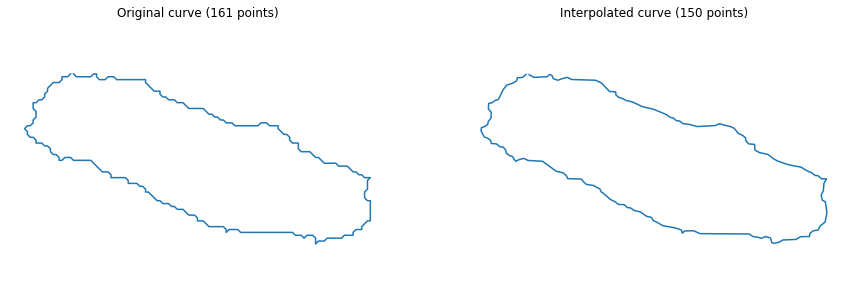

In [39]:
i = gs.random.randint(len(cells))
cell = cells[i]
cell_interpolation = interpolate(cells[i], nb_sampling)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell[:, 0], cell[:, 1])
plt.axis('equal')
plt.title(f"Original curve ({len(cell)} points)")
plt.axis('off')

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis('equal')
plt.title(f"Interpolated curve ({nb_sampling} points)")
plt.axis('off');

In [40]:
for i in range(len(cells)):
    cells[i] = interpolate(cells[i], nb_sampling)

For a sample of control cells and a sample of treated cells, we hence obtained the following sets of curves (top row shows control, i.e. non-treated cells; bottom row shows treated cells):

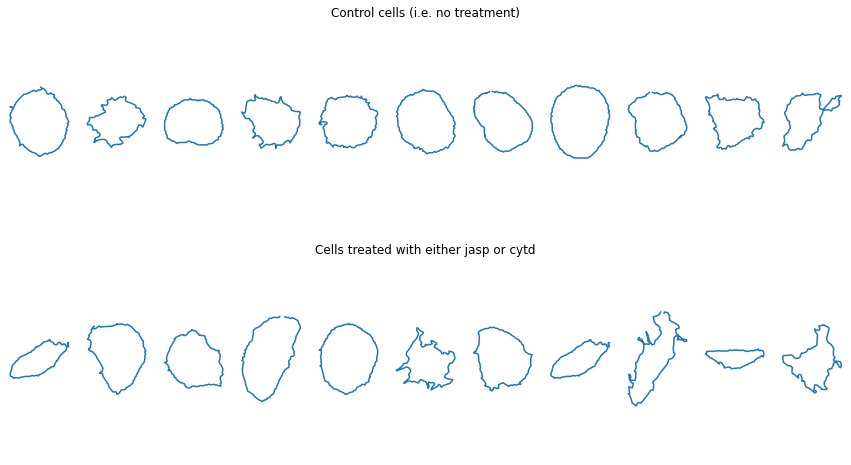

In [41]:
nb_cells = 11

control_i = gs.random.randint(0, 300, size=nb_cells)
jasp_i = gs.random.randint(500, 600, size=nb_cells)

fig = plt.figure(figsize=(15, 8))

for i in range(nb_cells):
    cell = cells[control_i[i]]
    fig.add_subplot(2, nb_cells, i + 1)
    plt.plot(cell[:, 0], cell[:, 1])
    if i == nb_cells//2:
        plt.title("Control cells (i.e. no treatment)")
    plt.axis('equal')
    plt.axis('off')
    
for i in range(nb_cells):
    cell = cells[jasp_i[i]]
    fig.add_subplot(2, nb_cells, i + nb_cells + 1)
    plt.plot(cell[:, 0], cell[:, 1])
    if i == nb_cells//2:
        plt.title("Cells treated with either jasp or cytd")
    plt.axis('equal')
    plt.axis('off')

Visual inspection of these curves seems to indicate more protusions appearing in treated cells, compared with control ones. This is in agreement with the physiological impact of the drugs, which are known to perturb the internal cytoskeleton connected to the cell membrane. Using the elastic metric, our goal will be to see if we can quantitatively confirm these differences.

### Alignment and re-parametrization

Our goal is to study the cell boundaries in our dataset, as points in a shape space of closed curves quotiented by translation, scaling, and rotation, so these transformations do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the L² distance) two sets of landmarks. Since we are working with closed curves, the starting point associated with the parametrization of the discrete curves is also arbitrary. Thus, we conduct an exhaustive search to find which parametrization produces the best alignment according to the above procedure (i.e. the distance to the base curve is the smallest). 

After running this protocol to align all the curves of the dataset against the first one (cf. next two blocks), our set of curves is now processed and ready for the analysis.

In [42]:
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric

m_ambient = 2
k_landmarks = nb_sampling

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
matrices_metric = preshape.embedding_metric

cells_preshape = preshape.projection(cells)

base_curve = cells_preshape[0]

def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift)%nb_sampling] for i in range(nb_sampling)]
        aligned = preshape.align(point=reparametrized, base_point=base_curve)
        distances[shift] = matrices_metric.norm(gs.array(aligned) - gs.array(base_curve))
    shift_min = gs.argmin(distances)
    reparametrized_min = [curve[(i + shift_min)%nb_sampling] for i in range(nb_sampling)]
    aligned_curve = preshape.align(point=reparametrized_min, base_point=base_curve)
    return aligned_curve

cells_shape = [exhaustive_align(curve, base_curve) for curve in cells_preshape]

Text(0.5, 1.0, 'Aligned curve')

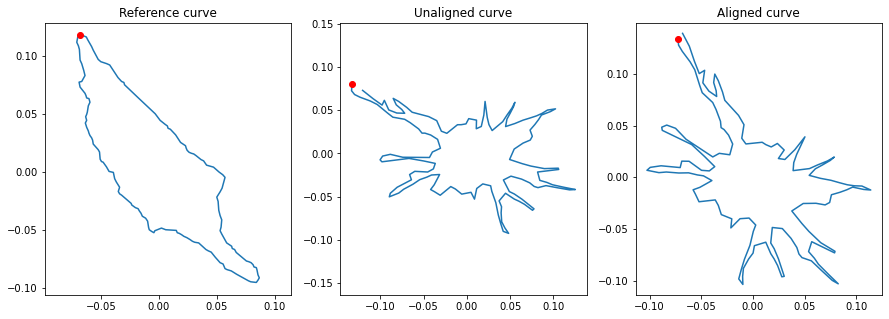

In [43]:
i = gs.random.randint(len(cells_shape))

base_cell = cells_preshape[0]
unaligned_cell = cells_preshape[i]
aligned_cell = cells_shape[i]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(base_cell[:, 0], base_cell[:, 1])
plt.plot(base_cell[0, 0], base_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Aligned curve")

In the plot above, the red dot shows the start of the parametrization of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve, which represents the first cell of the dataset. The starting point (in red) of this right curve has been also set to align with the reference.

## 2.3 Data analysis

### 2.3.A Geodesic trajectory joining two cell shapes

Using *Geomstats*, we can compute geodesics between discrete curves with respect to the elastic metric [(SKJJ2010)](#References). In our data, these geodesics represent trajectories between cell boundaries that minimize an elastic energy, and the length of the geodesic defines a distance between curves. We illustrate such a geodesic between two cells (run the block again to get a trajectory joining two other randomly chosen cells):

In [73]:
i, j = gs.random.randint(len(cells_shape), size=2)

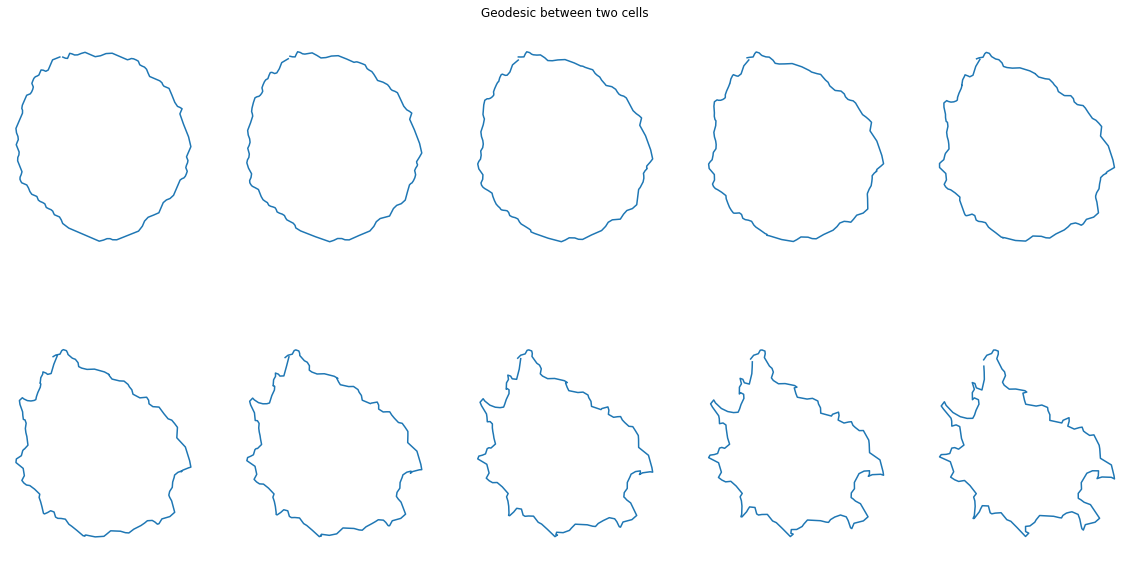

In [97]:
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric

curves = DiscreteCurves(R2)
metric = curves.square_root_velocity_metric

geodesic = metric.geodesic(initial_curve=cells_shape[i], end_curve=cells_shape[j])

points = geodesic(gs.linspace(0., 1., 10))

fig = plt.figure(figsize = (20, 10))
plt.title("Geodesic between two cells")
plt.axis('off')

for i, curve in enumerate(points):
    fig.add_subplot(2, len(points)/2, i + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis('equal')
    plt.axis('off')

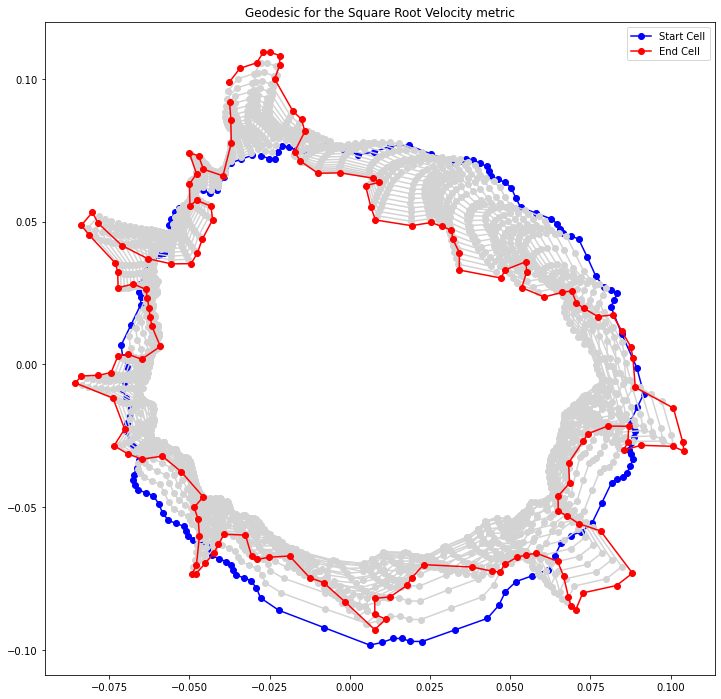

In [266]:
n_times = 20
times = gs.linspace(0., 1., n_times)

geod = geodesic(times)

plt.figure(figsize=(12, 12))
plt.plot(geod[0, :, 0], geod[0, :, 1], 'o-b', label="Start Cell")
for i in range(1, n_times - 1):
    plt.plot(geod[i, :, 0], geod[i, :, 1], 'o-', color="lightgrey")
plt.plot(geod[-1, :, 0], geod[-1, :, 1], 'o-r', label="End Cell")
plt.title('Geodesic for the Square Root Velocity metric')
plt.legend()
plt.show()

plotting 0plotting 1
plotting 2

plotting 3plotting 4

plotting 5plotting 6plotting 7
plotting 8
plotting 9


plotting 10
plotting 11
plotting 12
plotting 13plotting 14plotting 15


plotting 16
plotting 17
plotting 18
plotting 19


ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      5

0

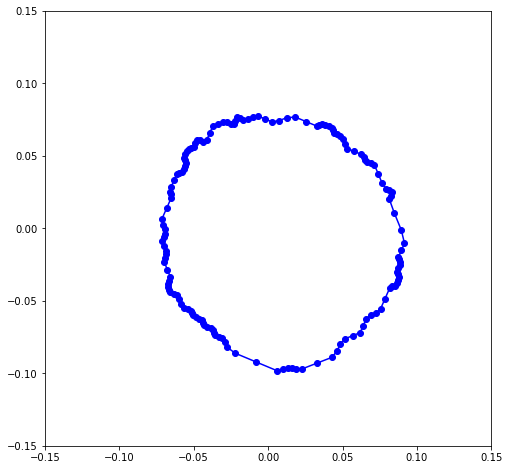

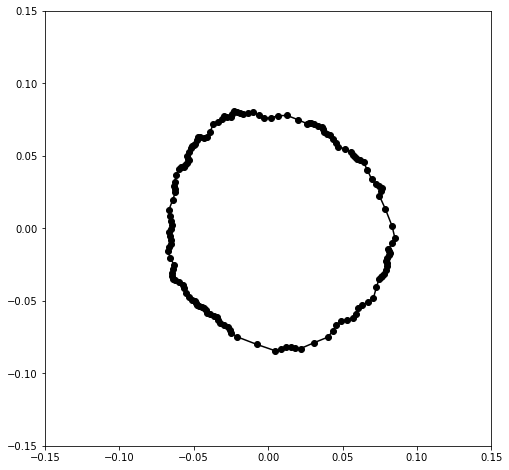

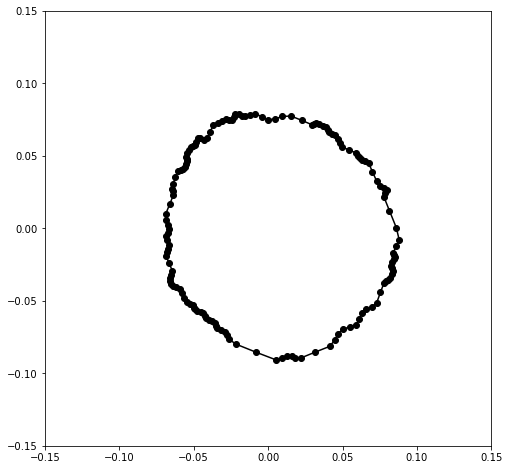

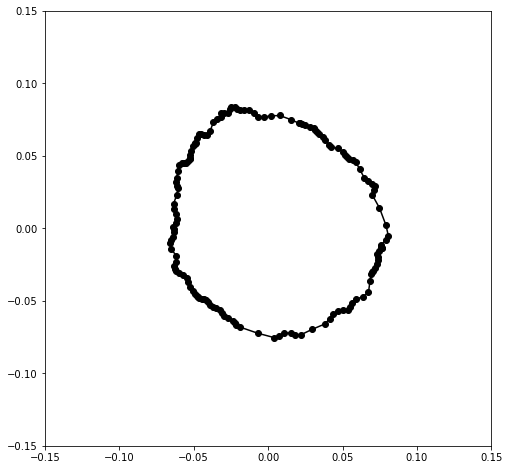

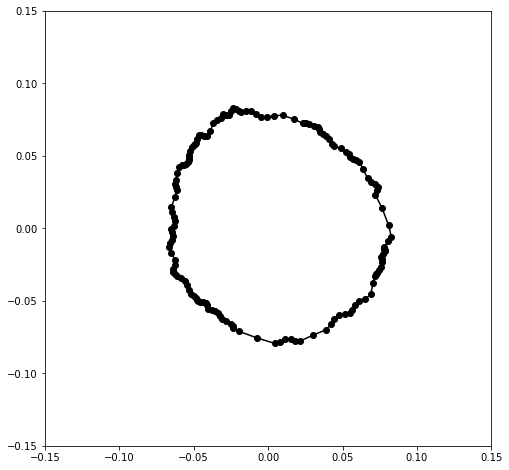

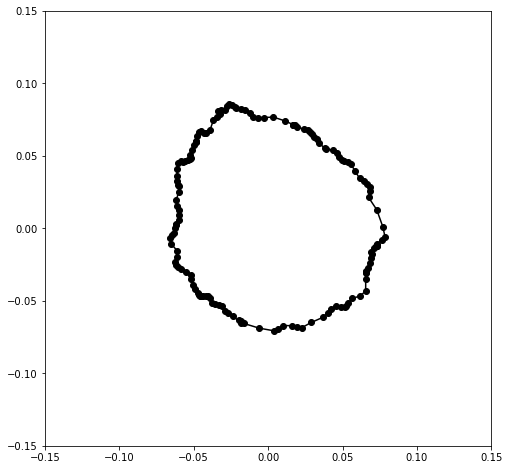

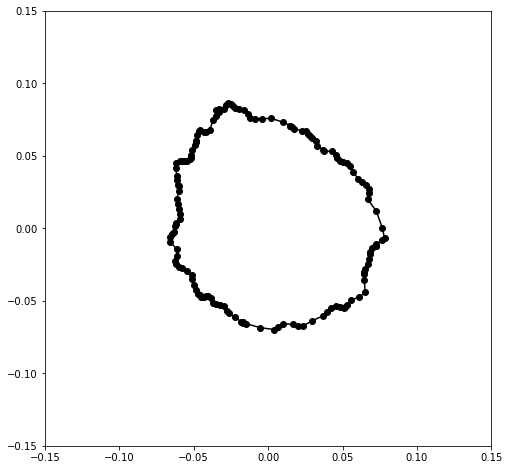

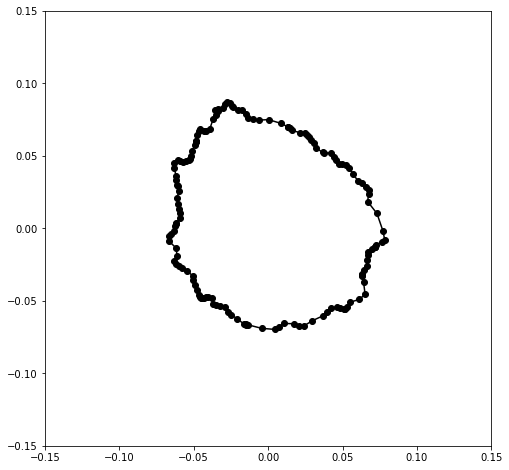

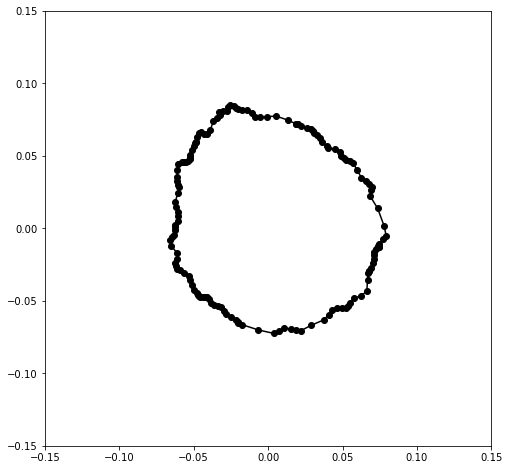

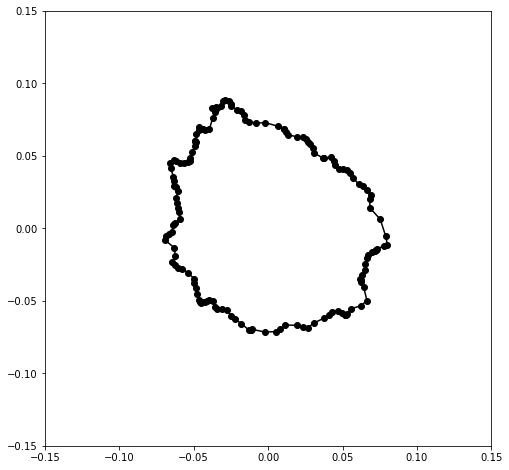

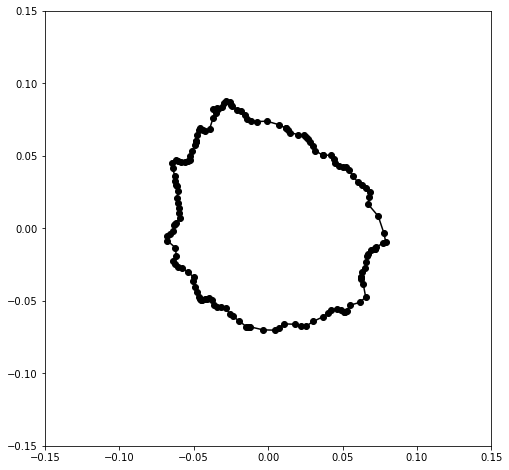

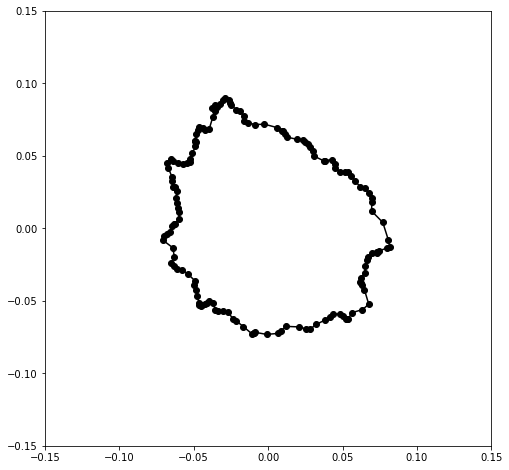

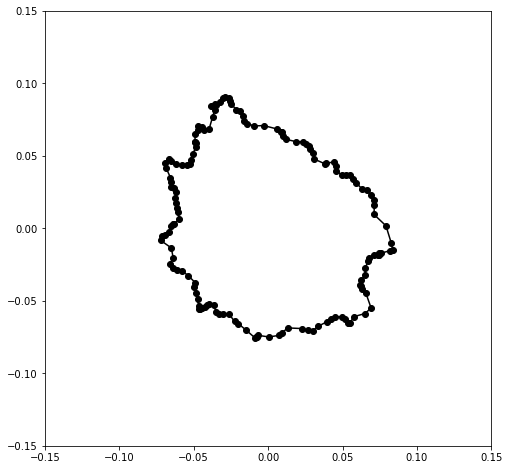

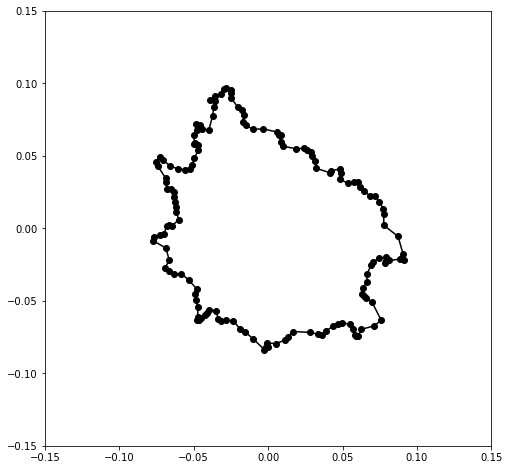

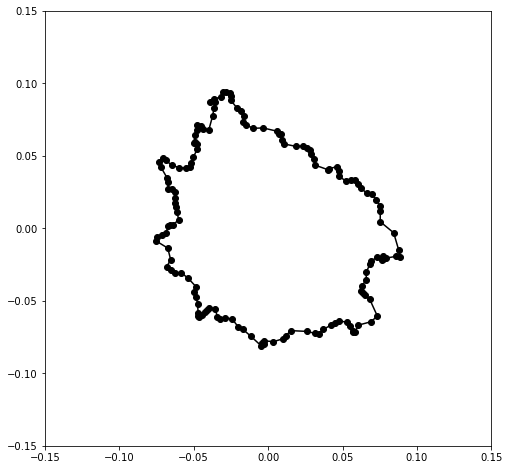

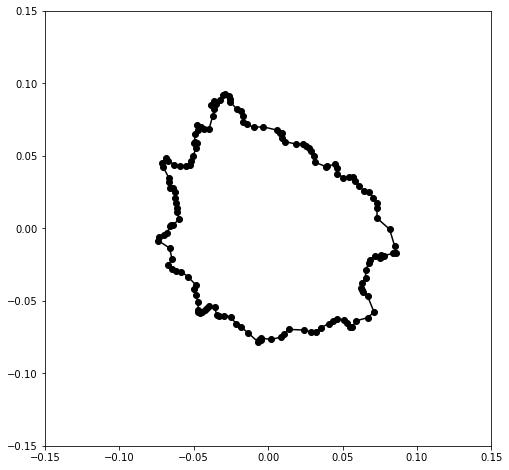

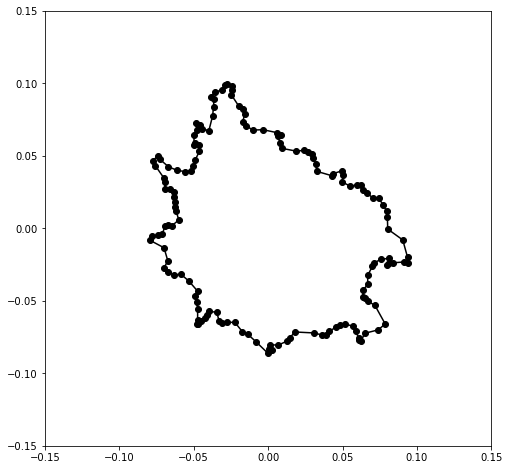

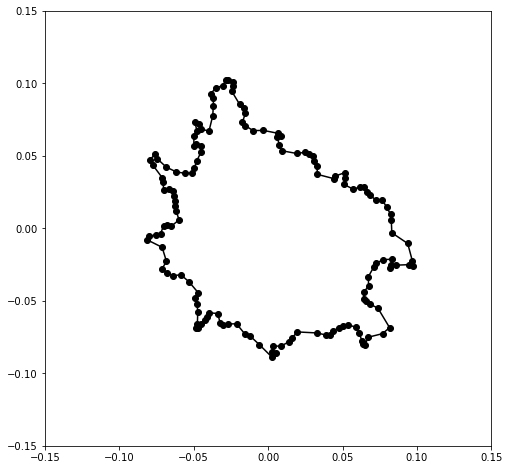

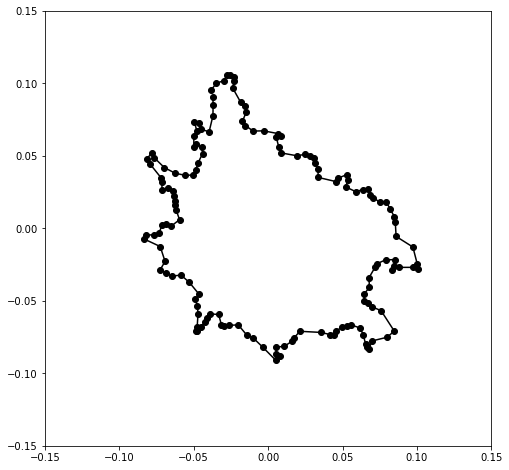

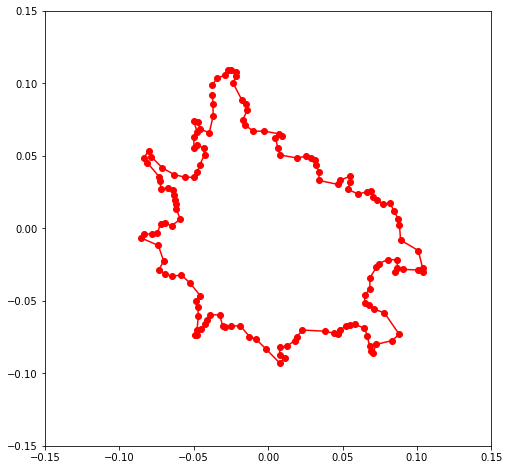

In [267]:
from joblib import Parallel, delayed, parallel_backend
import numpy as np
import matplotlib.pyplot as plt
import os

IMG_PREFIX = "geodesic_a"

def plot_image(i):
    print(f"plotting {i}")
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    if i == 0:
        ax.plot(geod[i, :, 0], geod[i, :, 1], 'o-b')
    elif i == n_times-1:
        ax.plot(geod[i, :, 0], geod[i, :, 1], 'o-r')
    else:
        ax.plot(geod[i, :, 0], geod[i, :, 1], 'o-k')
    ax.set_xlim((-0.15, 0.15))
    ax.set_ylim((-0.15, 0.15))
    fig.savefig(f"{IMG_PREFIX}{i:04d}.png")
    
with parallel_backend("threading", n_jobs=-1):
    Parallel()(delayed(plot_image)(i) for i in range(n_times))

os.system(
    f"ffmpeg -i {IMG_PREFIX}%04d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4"
)

In [88]:
cells_shape_arr = np.stack(cells_shape)
cells_shape_arr.shape

(650, 150, 2)

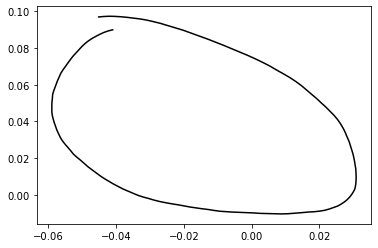

In [146]:
from geomstats.learning.frechet_mean import FrechetMean

cells_test = np.vstack([cells_shape_arr[:138], cells_shape_arr[139:]])

mean = FrechetMean(metric=curves.square_root_velocity_metric, point_type="matrix")
mean.fit(cells_test)

mean_estimate = mean.estimate_

plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black");

(649, 150, 2)


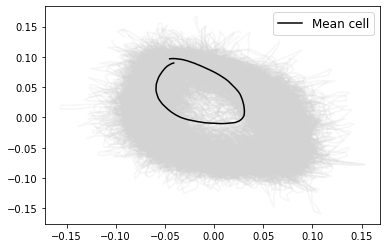

In [250]:
print(cells_test.shape)
for cell in cells_test:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)
    
plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black", label="Mean cell")
plt.legend(fontsize=12);

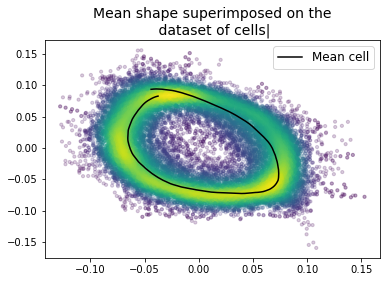

In [313]:
from scipy.stats import gaussian_kde

mean_estimate_aligned = 1.55 * (mean_estimate - np.mean(mean_estimate, axis=0))


cells_to_plot=cells_test[gs.random.randint(len(cells_test), size=200)]
points_to_plot = cells_to_plot.reshape(-1, 2)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / np.max(z)

plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1], alpha=0.2, c=z_norm, s=10)
plt.plot(mean_estimate_aligned[:, 0], mean_estimate_aligned[:, 1], "black", label="Mean cell")
plt.legend(fontsize=12)
plt.title("Mean shape superimposed on the\n dataset of cells|", fontsize=14);

In [154]:
dist_to_mean = []
for cell in cells_test:
    dist_to_mean.append(curves.square_root_velocity_metric.dist(mean_estimate, cell)[0])

In [ ]:
dist_to_mean[:5]

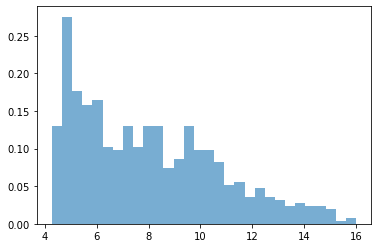

In [212]:
plt.hist(dist_to_mean, density=True, bins=30, alpha=0.6);

In [222]:
treatments_test = treatments[:138] + treatments[139:]
print(len(treatments_test))

lines_test = cell_lines[:138] + cell_lines[139:]
print(len(lines_test))

649
649


In [170]:
dists_control = []
dists_jasp = []
dists_cytd = []

for one_dist, one_treat in zip(dist_to_mean, treatments_test):
    if one_treat == "control":
        dists_control.append(one_dist)
    elif one_treat == "jasp":
        dists_jasp.append(one_dist)
    elif one_treat == "cytd":
        dists_cytd.append(one_dist)

In [191]:
from scipy import stats

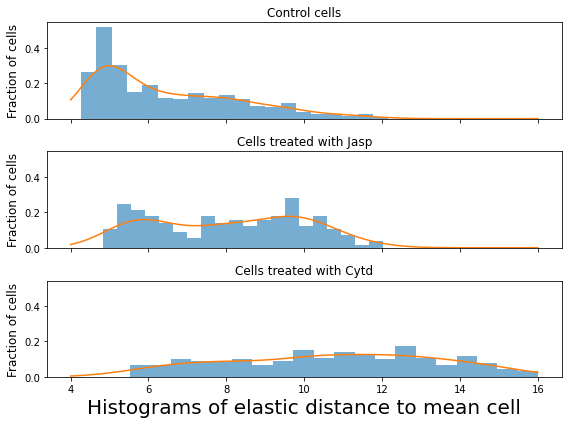

In [221]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, tight_layout=True, figsize=(8, 6))

axs[0].hist(dists_control, bins=20, alpha=0.6, density=True)
kde = stats.gaussian_kde(dists_control)
xx = np.linspace(4, 16, 100)
axs[0].plot(xx, kde(xx))
axs[0].set_title("Control cells")
axs[0].set_ylabel("Fraction of cells", fontsize=12)

axs[1].hist(dists_jasp, bins=20, alpha=0.6, density=True)
kde = stats.gaussian_kde(dists_jasp)
xx = np.linspace(4, 16, 100)
axs[1].plot(xx, kde(xx))
axs[1].set_title("Cells treated with Jasp")
axs[1].set_ylabel("Fraction of cells", fontsize=12)

axs[2].hist(dists_cytd, bins=20, alpha=0.6, density=True)
kde = stats.gaussian_kde(dists_cytd)
xx = np.linspace(4, 16, 100)
axs[2].plot(xx, kde(xx))
axs[2].set_title("Cells treated with Cytd")
axs[2].set_ylabel("Fraction of cells", fontsize=12)
axs[2].set_xlabel("Histograms of elastic distance to mean cell", fontsize=20);

In [218]:
import scipy

print("Test equality of means control vs jasp")
display(scipy.stats.ttest_ind(dists_control, dists_jasp, equal_var=False))

print("\nTest equality of means control vs cytd")
display(scipy.stats.ttest_ind(dists_control, dists_cytd, equal_var=False))

print("\nTest equality of means control vs cytd")
display(scipy.stats.ttest_ind(dists_cytd, dists_jasp, equal_var=False))

Test equality of means control vs jasp


Ttest_indResult(statistic=-8.814231439838135, pvalue=1.0827153409681295e-16)


Test equality of means control vs cytd


Ttest_indResult(statistic=-18.828164881276155, pvalue=1.2362540689854312e-50)


Test equality of means control vs cytd


Ttest_indResult(statistic=10.39996437144415, pvalue=5.653808127915026e-22)

In [224]:
dists_control_dlm8 = []
dists_control_dunn = []
dists_jasp_dlm8 = []
dists_jasp_dunn = []
dists_cytd_dlm8 = []
dists_cytd_dunn = []

for one_dist, one_treat, one_line in zip(dist_to_mean, treatments_test, lines_test):
    if one_treat == "control" and one_line == "dlm8":
        dists_control_dlm8.append(one_dist)
    elif one_treat == "control" and one_line == "dunn":
        dists_control_dunn.append(one_dist)
    elif one_treat == "jasp" and one_line == "dlm8":
        dists_jasp_dlm8.append(one_dist)
    elif one_treat == "jasp" and one_line == "dunn":
        dists_jasp_dunn.append(one_dist)
    elif one_treat == "cytd" and one_line == "dlm8":
        dists_cytd_dlm8.append(one_dist)
    elif one_treat == "cytd" and one_line == "dunn":
        dists_cytd_dunn.append(one_dist)

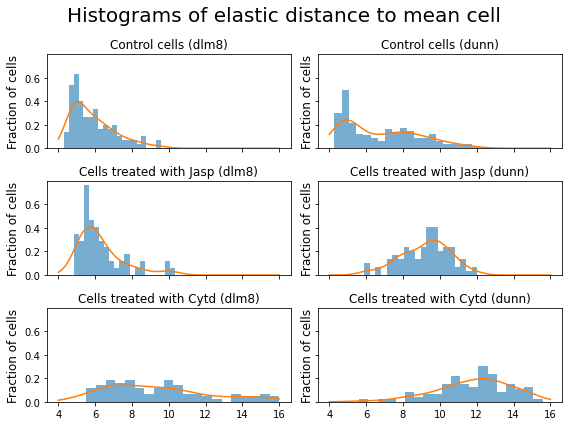

In [231]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, tight_layout=True, figsize=(8, 6))

axs[0, 0].hist(dists_control_dlm8, bins=20, alpha=0.6, density=True)
kde = stats.gaussian_kde(dists_control_dlm8)
xx = np.linspace(4, 16, 100)
axs[0, 0].plot(xx, kde(xx))
axs[0, 0].set_title("Control cells (dlm8)")
axs[0, 0].set_ylabel("Fraction of cells", fontsize=12)

axs[1, 0].hist(dists_jasp_dlm8, bins=20, alpha=0.6, density=True)
kde = stats.gaussian_kde(dists_jasp_dlm8)
xx = np.linspace(4, 16, 100)
axs[1, 0].plot(xx, kde(xx))
axs[1, 0].set_title("Cells treated with Jasp (dlm8)")
axs[1, 0].set_ylabel("Fraction of cells", fontsize=12)

axs[2, 0].hist(dists_cytd_dlm8, bins=20, alpha=0.6, density=True)
kde = stats.gaussian_kde(dists_cytd_dlm8)
xx = np.linspace(4, 16, 100)
axs[2, 0].plot(xx, kde(xx))
axs[2, 0].set_title("Cells treated with Cytd (dlm8)")
axs[2, 0].set_ylabel("Fraction of cells", fontsize=12)


axs[0, 1].hist(dists_control_dunn, bins=20, alpha=0.6, density=True)
kde = stats.gaussian_kde(dists_control_dunn)
xx = np.linspace(4, 16, 100)
axs[0, 1].plot(xx, kde(xx))
axs[0, 1].set_title("Control cells (dunn)")
axs[0, 1].set_ylabel("Fraction of cells", fontsize=12)

axs[1, 1].hist(dists_jasp_dunn, bins=20, alpha=0.6, density=True)
kde = stats.gaussian_kde(dists_jasp_dunn)
xx = np.linspace(4, 16, 100)
axs[1, 1].plot(xx, kde(xx))
axs[1, 1].set_title("Cells treated with Jasp (dunn)")
axs[1, 1].set_ylabel("Fraction of cells", fontsize=12)

axs[2, 1].hist(dists_cytd_dunn, bins=20, alpha=0.6, density=True)
kde = stats.gaussian_kde(dists_cytd_dunn)
xx = np.linspace(4, 16, 100)
axs[2, 1].plot(xx, kde(xx))
axs[2, 1].set_title("Cells treated with Cytd (dunn)")
axs[2, 1].set_ylabel("Fraction of cells", fontsize=12)

fig.suptitle("Histograms of elastic distance to mean cell", fontsize=20);

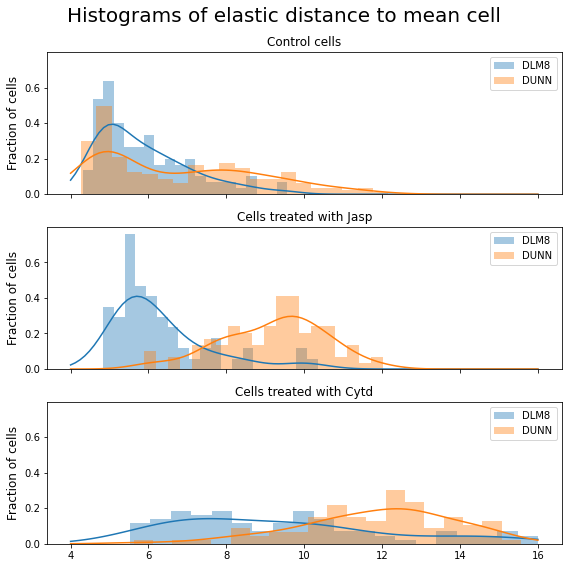

In [245]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))

axs[0].hist(dists_control_dlm8, bins=20, alpha=0.4, density=True, color="C0", label="DLM8")
kde = stats.gaussian_kde(dists_control_dlm8)
xx = np.linspace(4, 16, 100)
axs[0].plot(xx, kde(xx), color="C0")
axs[0].hist(dists_control_dunn, bins=20, alpha=0.4, density=True, color="C1", label="DUNN")
kde = stats.gaussian_kde(dists_control_dunn)
xx = np.linspace(4, 16, 100)
axs[0].plot(xx, kde(xx), color="C1")
axs[0].set_title("Control cells")
axs[0].set_ylabel("Fraction of cells", fontsize=12)
axs[0].legend()


axs[1].hist(dists_jasp_dlm8, bins=20, alpha=0.4, density=True, color="C0", label="DLM8")
kde = stats.gaussian_kde(dists_jasp_dlm8)
xx = np.linspace(4, 16, 100)
axs[1].plot(xx, kde(xx), color="C0")
axs[1].hist(dists_jasp_dunn, bins=20, alpha=0.4, density=True, color="C1", label="DUNN")
kde = stats.gaussian_kde(dists_jasp_dunn)
xx = np.linspace(4, 16, 100)
axs[1].plot(xx, kde(xx), color="C1")
axs[1].set_title("Cells treated with Jasp")
axs[1].set_ylabel("Fraction of cells", fontsize=12)
axs[1].legend()


axs[2].hist(dists_cytd_dlm8, bins=20, alpha=0.4, density=True, color="C0", label="DLM8")
kde = stats.gaussian_kde(dists_cytd_dlm8)
xx = np.linspace(4, 16, 100)
axs[2].plot(xx, kde(xx), color="C0")
axs[2].hist(dists_cytd_dunn, bins=20, alpha=0.4, density=True, color="C1", label="DUNN")
kde = stats.gaussian_kde(dists_cytd_dunn)
xx = np.linspace(4, 16, 100)
axs[2].plot(xx, kde(xx), color="C1")
axs[2].set_title("Cells treated with Cytd")
axs[2].set_ylabel("Fraction of cells", fontsize=12)
axs[2].legend()

fig.suptitle("Histograms of elastic distance to mean cell", fontsize=20);

# 3. Benchmark

## 3.1 Geodesic trajectory

First, here is a qualitative comparison between a geodesic with respect to the elastic metric and a linear geodesic.<br>
A llinear geodesic between curves $c_0$ and $c_1$ can be parametrized as $(1-t)c_0 + tc_1$ for $0 \leq t \leq 1$.

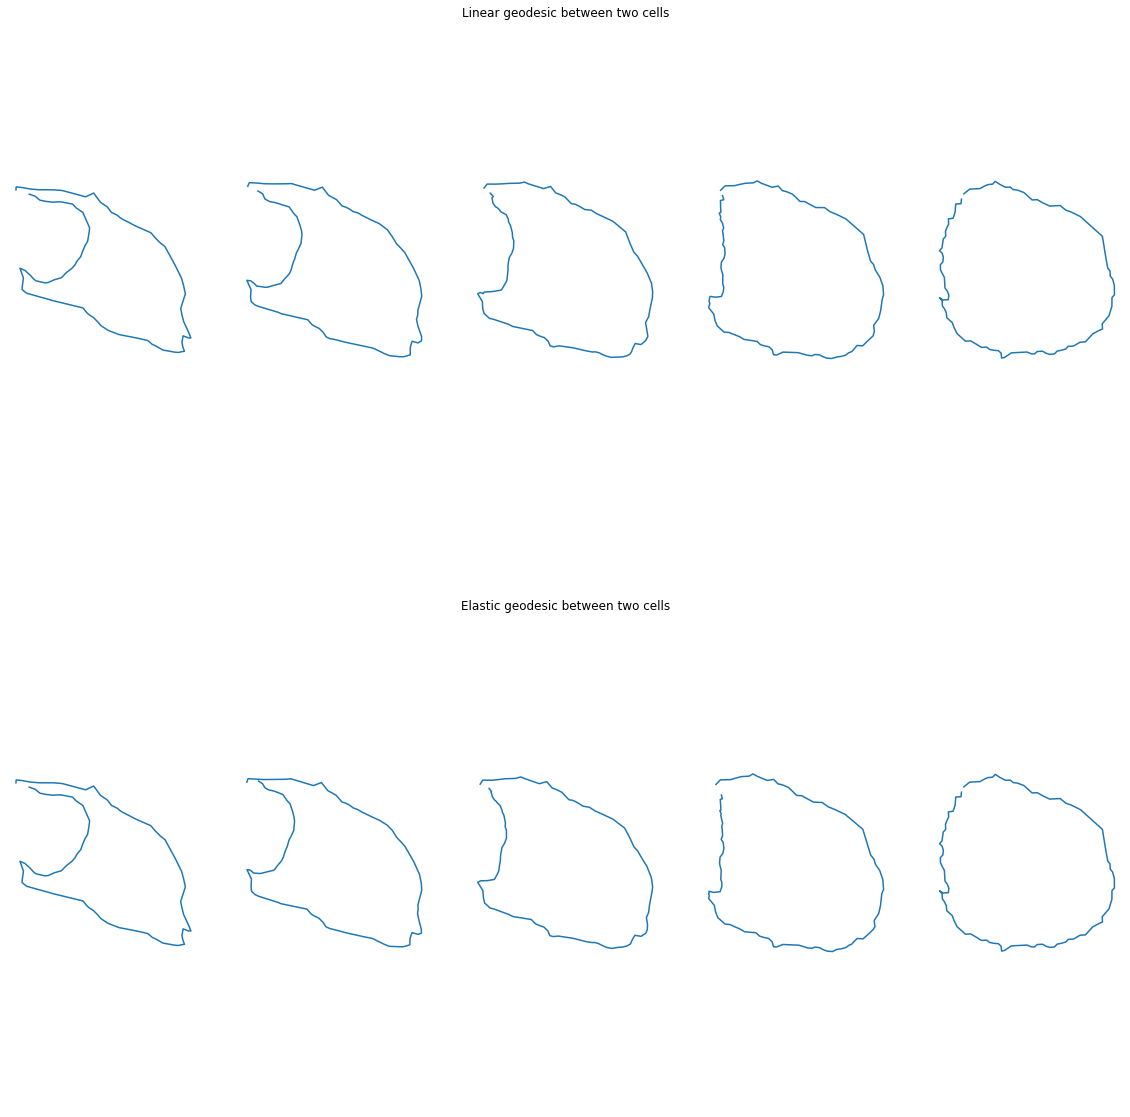

In [81]:
def linear_geodesic(initial_curve, end_curve, t):
    """Compute the curve at time t in the linear geodesic
    between initial_curve and end_curve.
    
    Returns
    -------
    curve : discrete curve
    """
    curve = (1 - t)*initial_curve + t*end_curve
    return curve

i, j = gs.random.randint(len(cells_shape), size=2)

points_linear = [linear_geodesic(cells_shape[i], cells_shape[j], t) for t in gs.linspace(0., 1., 5)]

fig = plt.figure(figsize = (20, 10))
plt.title("Linear geodesic between two cells")
plt.axis('off')

for k, curve in enumerate(points_linear):
    fig.add_subplot(2, 5, k + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis('equal')
    plt.axis('off')
    
geodesic = metric.geodesic(initial_curve=cells_shape[i], end_curve=cells_shape[j])
points_elastic = geodesic(gs.linspace(0., 1., 5))
    
for i, curve in enumerate(points_elastic):
    fig.add_subplot(2, 5, i + 6)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis('equal')
    plt.axis('off')
    if i == 2:
        plt.title("Elastic geodesic between two cells")

We can see that the two geodesics are not that different from each other. Sometimes, we can spot geometric aberration for the linear geodesic (intersections). However, the advantage that they have is that the curves remain closed along the geodesic.

## 3.2 Classification of cell lines

In 2016, Lyons and al. used a neural network to classify cells from the same dataset [(LAM2016)](#References). In their study, each cell was represented as a vector of geometric features.

Our dataset is a subset of theirs, and all the cells we are studying were observed with the GDA substrate. Thus, we can compare the accuracies of the two methods, and compare these accuracies with the ones we obtained with treated cells.

Neural network with geometric features: 0.69<br>
SVM with MDS on elastic curves: 0.63<br>
SVM with MDS on elastic curves (cytd treatment) : 0.72<br>
SVM with MDS on elastic curves (jasp treatment) : 0.87

# 4. Limitations and perspectives

### Limitations of this analysis

While our analysis focuses on the shape of the cell external membrane, other features can be taken into account and used in practice to analyze cell shapes, including the shape of the nucleus, actin structure (affecting the image texture), other geometric measures such as circularity or aspect ratio [(MGCKCKDDRTWSBCC2018, AXCFP2019)](#References). Interestingly, our single metric is able to produce good predictions in some cases, suggesting that the cell boundary shape also captures intra-cellular processes.

The data preprocessing that was done can also be optimized and improved, although it was performing well enough in our dataset. To compensate for the lack of features on discrete curves, we used functions from Geomstats that were originally designed for sets of landmarks in Kendall's shape space, and not the space of discrete elatic curves, which uses a different metric. Doing an exhaustive search to re-parametrize with the best starting point can also reveal to be unpractical as the dataset size, or the number of sampling points in each curve increase.

While being physically sound, the use of the elastic metric to visualize cell deformation may also not exactly reflect the dynamical changes that cells undergo. It would be interesting to study videos, instead of static images, to compare our numerical geodesics and the observed morphological trajectories and get a better understanding of the shape spaces where cells live in.

### Limitations of Geomstats

The first limitation that we faced is that Geomstats current implementation only deals with open curves. This restriction to open curves was not very clear when we first looked at the documentation. In the context of our application, having an implementation with closed curves would be quite relevant as cell boundaries are naturally closed. In this analysis, the cell boundaries were thus studied as open curves, which tends to produce some unrealistic distance between the two extreme points of the curves along a geodesic, which are considered to be open curves in the current framework of the package. 

To compare curves, we also had to preprocess the data, to take into account the fact that Geomstats does not consider that cells are defined up to transformations (such as rotations). As an example, we did the following experiement, to plot the geodesic trajectory between two simple shapes (squares and circles): While the starting points should not be relevant when analyzing closed curves and producing grodesic trajectories, having two unaligned starting points can produce undesired deformations that would move the curves to align them.

In [82]:
def unit_square(nb_points_side):
    """Generate a discrete curve representing a square 
    with nb_points_side sampling points by side.
    
    Returns
    -------
    square : discrete curve
    """
    nb_points = 2*(nb_points_side) + 2*(nb_points_side - 2)
    square = gs.zeros((nb_points, 2))
    
    pos_axis = gs.linspace(-1, 1, nb_points_side)
    neg_axis = gs.flip(pos_axis)
    ones = gs.ones(nb_points_side)
    minus_ones = -ones
    
    right = gs.vstack((pos_axis, minus_ones)).T
    top = gs.vstack((ones, pos_axis)).T
    left = gs.vstack((neg_axis, ones)).T
    bottom = gs.vstack((minus_ones, neg_axis)).T[:nb_points_side - 1]
    
    square[:nb_points_side] = right
    square[nb_points_side - 1 : 2*nb_points_side - 1] = top
    square[2*nb_points_side - 2 : 3*nb_points_side - 2] = left
    square[3*nb_points_side - 3 : 4*nb_points_side - 4] = bottom
    return square

def unit_circle(nb_points):
    """Generate a discrete curve with nb_points sampling points 
    representing the unit circle.
    
    Returns
    -------
    circle : discrete curve
    """
    t = gs.linspace(0, 2*gs.pi, nb_points + 1)[: -1]
    x = gs.cos(t)
    y = gs.sin(t)
    circle = gs.vstack((x, y)).T
    return circle

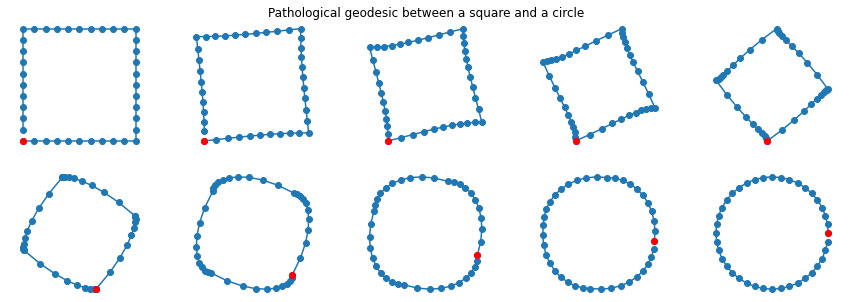

In [83]:
curves = DiscreteCurves(R2)
metric = curves.square_root_velocity_metric

square = unit_square(11)
circle = unit_circle(40)

geodesic = metric.geodesic(initial_curve=square, end_curve=circle)

points = geodesic(gs.linspace(0., 1., 10))

fig = plt.figure(figsize = (15, 5))
plt.title("Pathological geodesic between a square and a circle")
plt.axis('off')

for i in range(len(points)):
    fig.add_subplot(2, len(points)/2, i + 1)
    curve = points[i]
    plt.plot(curve[:, 0], curve[:, 1], '-o')
    plt.plot(curve[0, 0], curve[0, 1], 'ro')
    plt.axis('equal')
    plt.axis('off')

For this analysis, we also tried to project the dataset in 2D using a PCA on the tangent space at the Frechet mean, as done in another Geomstats notebook. However, this did not work because an exception was raised, due to the implementation missing for this manifold.

Finally, with the presence of high variability in shape in our data, we planned to do more statistical analysis and compare empirical variances between classes, e.g. doing an equivalent of Barlett's test . However, we did not succeed at computing the Frechet means (necessary to compute variances), as the current implementation of Geomstats does not allow it for discrete curves (error message mentioned some part of the implementation missing). We tried to fix it by implementing a new inner_product method in the SRVMetric class in the local repository and opened an issue (https://github.com/geomstats/geomstats/issues/995). With a better understanding of the current implementation, we could possibly contribute to improving this aspect of the package.<br>

### Proposed features of Geomstats

There are references [(e.g. BBMM2014)](#References) that propose methods to study shapes of (open or closed) curves as quotient spaces, invariant by translation, scaling, rotation and reparametrization. As some use the square root velocity representation that is already implemented in Geomstats, the current framework of Geomstats could in principle be extended to deal with such spaces and to add closed curves.

In this study, we specifically considered the elastic metric, whose physical interpretation is quite relevant to the study of physical objects like cells. Furthermore, this metric belongs to a larger family of metrics defined by two parameters that quantify the cost of bending and stretching [(MSJ2007)](#References). It would thus be interesting to estimate the bending and stretching parameters that match an experimental observed trajectory of cell shape, to study the biomechanical forces associated with it. While the elastic metric that is currently implemented in the square root velocity framework only corresponds to a specific couple of parameters, generalizing the implementation with a choice for these parameters would be useful to study morphological trajectories. Such an implementation can be naturally done by using a generalization of the square root velocity vector [(BBMM2014)](#References).

## References


(AXCFP2019) Alizadeh E, Xu W, Castle J, Foss J, Prasad A. TISMorph: A tool to quantify texture, irregularity and spreading of single cells. PloS one. 2019 Jun 3;14(6):e0217346.

(MGCKCKDDRTWSBCC2018) McQuin C, Goodman A, Chernyshev V, Kamentsky L, Cimini BA, Karhohs KW, Doan M, Ding L, Rafelski SM, Thirstrup D, Wiegraebe W, Singh S, Becker T, Caicedo JC, Carpenter AE (2018). CellProfiler 3.0: Next-generation image processing for biology. PLoS Biol. 16(7):e2005970 / doi. PMID: 29969450

(LAM2016) Lyons SM, Alizadeh E, Mannheimer J, et al. Changes in cell shape are correlated with metastatic potential in murine and human osteosarcomas. Biol Open. 2016;5(3):289-299. Published 2016 Feb 12. doi:10.1242/bio.013409

(BBMM2014) Bauer M, Bruveris M, Marsland S, Michor PW. Constructing reparameterization invariant metrics on spaces of plane curves. Differential Geometry and its Applications. 2014 Jun 1;34:139-65.

(SKJJ2010) Srivastava A, Klassen E, Joshi SH, Jermyn IH. Shape analysis of elastic curves in euclidean spaces. IEEE Transactions on Pattern Analysis and Machine Intelligence. 2010 Oct 14;33(7):1415-28.

(MSJ2007) Mio W, Srivastava A, Joshi S. On shape of plane elastic curves. International Journal of Computer Vision. 2007 Jul 1;73(3):307-24.